<a href="https://colab.research.google.com/github/rorode8/Tensor/blob/main/p2p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


paper: https://arxiv.org/pdf/1611.07004.pdf#page=8&zoom=100,412,492

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#root
PATH = "/content/drive/MyDrive/Dataset"

INPATH = PATH + "/input"

OUTPATH = PATH + "/output2"

CHPATH = PATH + "/checkpoints"

imgurls = !ls -1 "{OUTPATH}"


In [ ]:
%tensorflow_version 2.x

In [ ]:
imgurls

['100.jpg',
 '101.jpg',
 '102.jpg',
 '103.jpg',
 '104.jpg',
 '105.jpg',
 '106.jpg',
 '107.jpg',
 '108.jpg',
 '109.jpg',
 '10.jpg',
 '110.jpg',
 '111.jpg',
 '112.jpg',
 '113.jpg',
 '114.jpg',
 '115.jpg',
 '115-mega.jpg',
 '116.jpg',
 '117.jpg',
 '118.jpg',
 '119.jpg',
 '11.jpg',
 '120.jpg',
 '121.jpg',
 '122.jpg',
 '123.jpg',
 '124.jpg',
 '125.jpg',
 '126.jpg',
 '127.jpg',
 '127-mega.jpg',
 '128.jpg',
 '129.jpg',
 '12.jpg',
 '130.jpg',
 '130-mega.jpg',
 '131.jpg',
 '132.jpg',
 '133.jpg',
 '134.jpg',
 '135.jpg',
 '136.jpg',
 '137.jpg',
 '138.jpg',
 '139.jpg',
 '13.jpg',
 '140.jpg',
 '141.jpg',
 '142.jpg',
 '142-mega.jpg',
 '143.jpg',
 '144.jpg',
 '145.jpg',
 '146.jpg',
 '147.jpg',
 '148.jpg',
 '149.jpg',
 '14.jpg',
 '150.jpg',
 '150-mega-x.jpg',
 '150-mega-y.jpg',
 '151.jpg',
 '152.jpg',
 '153.jpg',
 '154.jpg',
 '155.jpg',
 '156.jpg',
 '157.jpg',
 '158.jpg',
 '159.jpg',
 '15.jpg',
 '15-mega.jpg',
 '160.jpg',
 '161.jpg',
 '162.jpg',
 '163.jpg',
 '164.jpg',
 '165.jpg',
 '166.jpg',
 '167.jp

In [ ]:
n = 500
train_n = round(n*0.8)

randurls = np.copy(imgurls)

np.random.shuffle(randurls)

tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

819 400 100


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
import requests

def resize (inimg,tgimg, height, width):

  inimg = tf.image.resize(inimg,[height,width])
  tgimg = tf.image.resize(tgimg,[height,width])

  return inimg, tgimg

def normalize(inimg,tgimg):
  inimg = (inimg/127.5)-1
  tgimg = (tgimg/127.5)-1

  return inimg, tgimg

def random_jitter(inimg,tgimg):

  inimg,tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg,tgimg],axis=0)
  cropped_image = tf.image.random_crop(stacked_image,size=[2,IMG_HEIGHT,IMG_WIDTH,3])

  inimg,tgimg = cropped_image[0],cropped_image[1]

  if tf.random.uniform(()) > 0.5:

    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
  
  return inimg,tgimg

def load_image(filename, augment=True):

  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)),tf.float32)[..., :3]
  

  inimg,tgimg = resize(inimg,tgimg,IMG_HEIGHT,IMG_WIDTH)

  if augment:
    inimg,tgimg = random_jitter(inimg,tgimg)

  inimg,tgimg = normalize(inimg,tgimg)

  return inimg,tgimg

def load_instant(filenames, augment=True):

  inimg = tf.cast(tf.image.decode_jpeg(requests.get(filenames[0]).content),tf.float32)[..., :3]    
  tgimg = tf.cast(tf.image.decode_jpeg(requests.get(filenames[1]).content),tf.float32)[..., :3]  
  

  inimg,tgimg = resize(inimg,tgimg,IMG_HEIGHT,IMG_WIDTH)

  if augment:
    inimg,tgimg = random_jitter(inimg,tgimg)

  inimg,tgimg = normalize(inimg,tgimg)

  return inimg,tgimg

def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

def load_instant_image(filenames):
  return load_instant(filenames, False)


  

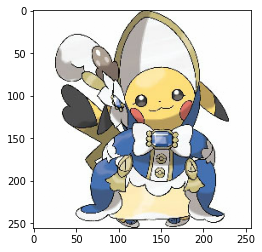

In [ ]:
plt.imshow(((load_instant_image(("https://i.imgur.com/ncT1jra.jpg","https://i.imgur.com/ksm09rd.jpg"))[1]) +1) /2)

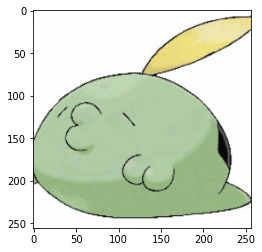

In [ ]:
#visualizar
plt.imshow(((load_train_image(randurls[72])[1]) +1) /2)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset= test_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

encoder

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import *

def downsample(filters, apply_batchnorm=True):

  result = Sequential()

  #normal gaussian
  initializer = tf.random_normal_initializer(0,0.02)

  #conv layer
  result.add(Conv2D(filters, 
             kernel_size=4,
             strides=2,
             padding="same",
             kernel_initializer = initializer,
             use_bias=not apply_batchnorm)) #bias = sesgo

  if apply_batchnorm:
    #batch normalization
    result.add(BatchNormalization())

  #activation
  result.add(LeakyReLU())

  return result



In [ ]:
#test
downsample(64)

decoder

In [ ]:
def upsample(filters, apply_dropout=False):

  result = Sequential()

  #normal gaussian
  initializer = tf.random_normal_initializer(0,0.02)

  #conv layer
  result.add(Conv2DTranspose(filters, 
                              kernel_size=4,
                              strides=2,
                              padding="same",
                              kernel_initializer = initializer,
                              use_bias=False))  

  
  #batch normalization
  result.add(BatchNormalization())

  if apply_dropout:
    #dropout layer , disconnect layer series randomly, regularizes neural network
    result.add(Dropout(0.5))

  #activation
  result.add(ReLU())

  return result

In [ ]:
#test
upsample(64)

Generator
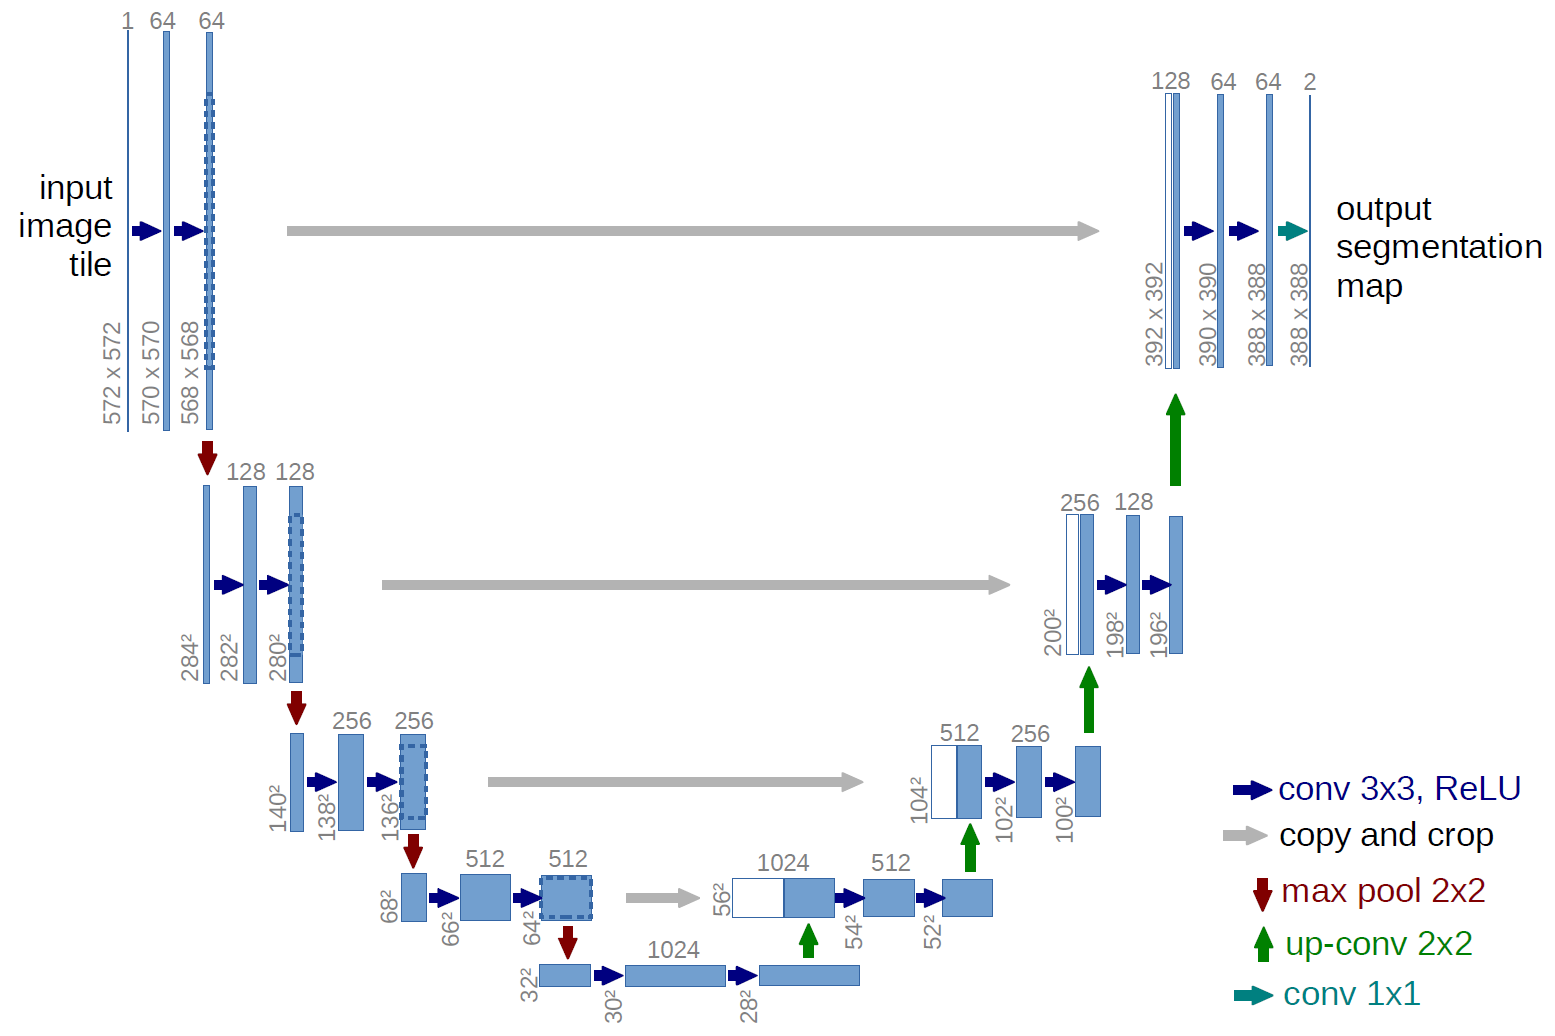

In [ ]:
def Generator():

  inputs = tf.keras.layers.Input(shape=[None,None,3]) #width and height are left open

  down_stack =[                                 #bs = batch size
          downsample(64,apply_batchnorm=False), #(bs, 128, 128, 64)
          downsample(128),
          downsample(256),
          downsample(512),
          downsample(512),
          downsample(512),
          downsample(512),
          downsample(512)                       #(bs, 1, 1, 512)
  ]

  up_stack = [
       upsample(512, apply_dropout=True),       #(bs, 2, 2, 1024)
       upsample(512, apply_dropout=True),
       upsample(512, apply_dropout=True),
       upsample(512),
       upsample(256),
       upsample(128),
       upsample(64)                             #(bs,128,128,128)
  ]
  #generates image, it's an upsampling
  last = Conv2DTranspose(filters = 3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = tf.random_normal_initializer(0,0.02),
                         activation = "tanh") #normalizes results to range (-1,1)
  
  x = inputs
  s = [] #skip connections
  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)
  
  s = reversed(s[:-1]) #reverse and delete last one
  for  up, sk in zip(up_stack, s):

    x = up(x)
    x = concat([x,sk])

  last_layer = last(x)
  
  return Model(inputs=inputs,outputs=last_layer)


In [ ]:
#test
generator = Generator()


discriminator

In [ ]:
def Discriminator():

  ini = Input(shape=[None,None,3], name="input_img")
  gen = Input(shape=[None,None,3], name="gener_img")

  con = concatenate([ini,gen])

  initializer = tf.random_normal_initializer(0,0.02)

  down1 = downsample(64,apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)
  
  return tf.keras.Model(inputs=[ini,gen], outputs=last)



In [ ]:
discriminator = Discriminator()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)  #normalize to (0,1)


In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):

  #Diferencia entre los true por ser real y el detectado por el disciminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  #mean absolute error (how far are our parameters from ideal)
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [ ]:
import os

generator_optimizer         = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_optimizer     = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

checkpoint_prefix = os.path.join(CHPATH,  "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [ ]:
#restores last checkpoint
checkpoint.restore(tf.train.latest_checkpoint(CHPATH)).expect_partial()

In [ ]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/imagesB/' + save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0],tar[0],prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.title(title[i])
      #get the pixel values between [0,1]
      plt.imshow(display_list[i]*0.5 + 0.5)
      plt.axis('off')
  
  plt.show()

In [ ]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training = True)

    output_trg_discr = discriminator([target, input_image], training = True)

    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

    gen_loss   = generator_loss(output_gen_discr, output_image, target)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))


In [ ]:
from IPython.display import clear_output

def train(dataset,epochs):
  for epoch in range(epochs):

    imgi = 0
    for input_image, target in dataset:
      print('epoch: '+ str(epoch) + ' - train: '+ str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)

      clear_output(wait=True)

    imgi = 0
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' +str(epoch), display_imgs=True)
      imgi+=1

    # saving (checkpoint) every 25
    if (epoch +1 ) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)


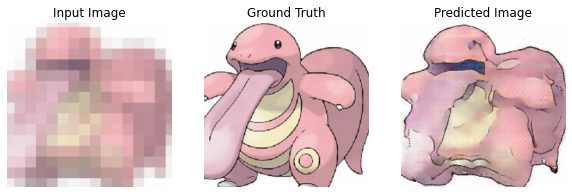

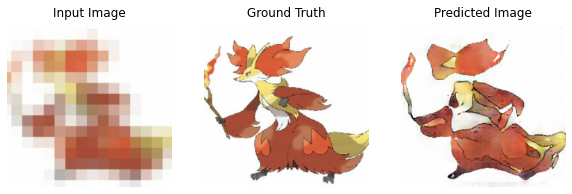

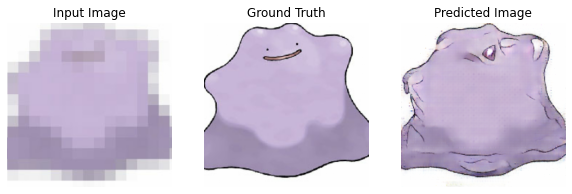

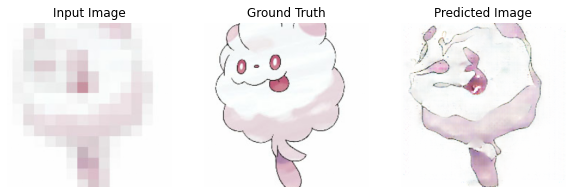

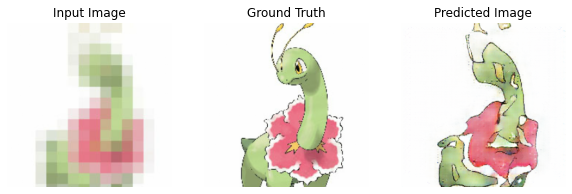

In [ ]:
train(train_dataset,200)

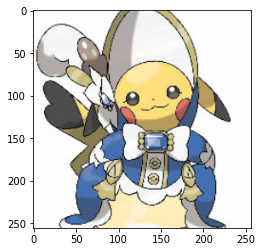

In [ ]:
plt.imshow(((load_instant(("https://i.imgur.com/ncT1jra.jpg","https://i.imgur.com/ksm09rd.jpg"))[1]) +1) /2)

In [ ]:
input_link, target_link =  "https://i.imgur.com/0Qv80GF.jpg" , "https://i.imgur.com/BxavnXw.jpg"

uno = tf.convert_to_tensor([(load_instant(("https://i.imgur.com/ncT1jra.jpg","https://i.imgur.com/ksm09rd.jpg"))[0])])
dos = tf.convert_to_tensor([(load_instant(("https://i.imgur.com/ncT1jra.jpg","https://i.imgur.com/ksm09rd.jpg"))[1])])

u1 = tf.convert_to_tensor([(load_instant((input_link,target_link))[0])])
d1 = tf.convert_to_tensor([(load_instant((input_link,target_link))[1])])

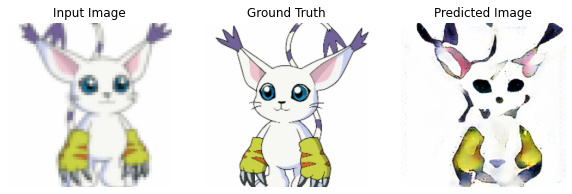

In [ ]:
generate_images(generator, u1,d1)